In [1]:
from typing import Union, Optional
from dataclasses import dataclass
import math

import tensorflow as tf
import numpy as np
import PIL.Image as Image

2021-11-14 20:56:21.056039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 20:56:21.056065: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.__version__

'2.7.0'

In [3]:
lena = Image.open("imgs/Lenna512.png")
chess = Image.open("imgs/ChessSet512.png")
imgs = [np.array(i) / 255.0 for i in [lena, chess]]
imgs

[array([[[0.87843137, 0.51372549, 0.42352941],
         [0.8745098 , 0.50980392, 0.42352941],
         [0.87058824, 0.52156863, 0.43529412],
         ...,
         [0.81568627, 0.39607843, 0.36862745],
         [0.78823529, 0.36078431, 0.32941176],
         [0.72156863, 0.30980392, 0.31764706]],
 
        [[0.88235294, 0.51372549, 0.41960784],
         [0.8745098 , 0.51372549, 0.41960784],
         [0.8745098 , 0.5254902 , 0.43137255],
         ...,
         [0.78823529, 0.38039216, 0.36078431],
         [0.74117647, 0.31372549, 0.30980392],
         [0.62745098, 0.21568627, 0.26666667]],
 
        [[0.88235294, 0.51764706, 0.41960784],
         [0.8745098 , 0.51764706, 0.41568627],
         [0.8745098 , 0.52156863, 0.42352941],
         ...,
         [0.74509804, 0.3372549 , 0.34901961],
         [0.6627451 , 0.25882353, 0.30588235],
         [0.54117647, 0.14117647, 0.24313725]],
 
        ...,
 
        [[0.31764706, 0.08235294, 0.23137255],
         [0.32156863, 0.07843137, 0.22745

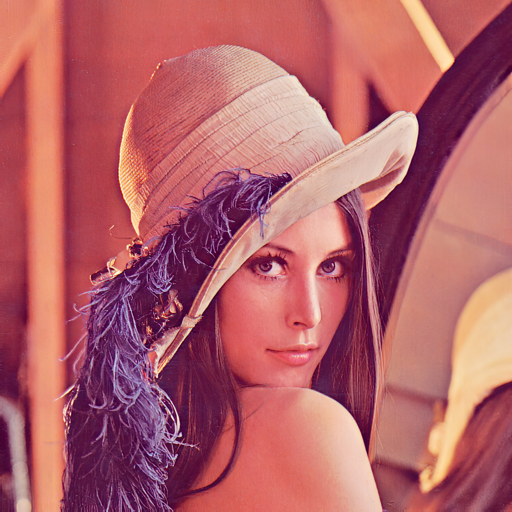

In [4]:
lena

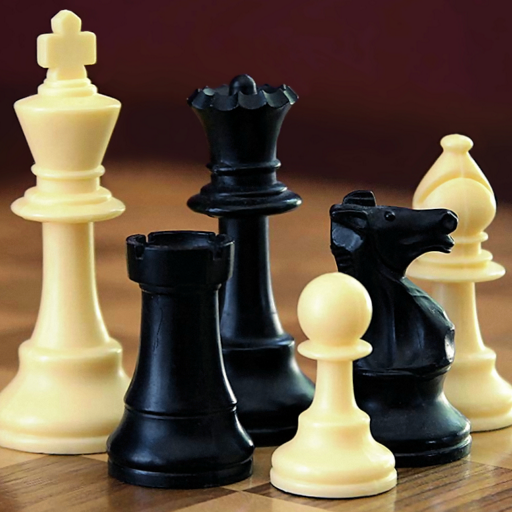

In [5]:
chess

In [6]:
def make_gauss_blur_kernel(size: int, scale: float = 3) -> np.ndarray:
    result = np.zeros(shape=[size], dtype=float)
    center = (size - 1) // 2
    div = ((center / scale) ** 2) * 2
    for i in range(size):
        x2 = (center - i)**2
        result[i] = math.exp( -x2 / div)
    return result / np.sum(result)

make_gauss_blur_kernel(11)

array([0.00266126, 0.01344761, 0.0474085 , 0.11660608, 0.20009684,
       0.23955941, 0.20009684, 0.11660608, 0.0474085 , 0.01344761,
       0.00266126])

In [7]:
@dataclass
class Report:
    image: np.ndarray
    gradient: np.ndarray
    image_source: np.ndarray
    loss_precise: float
    loss_gauss: float
    loss: float

class MyModel:
    def __init__(self, img_h: int, img_w: int, gauss_kernel_size: int, image_source: Optional[np.ndarray] = None):
        if image_source is None:
            image_source = np.zeros(shape=(1, img_h, img_w, 3), dtype=float)
        self.trainable_image = tf.Variable(initial_value=image_source, trainable=True)
        gauss_blur_kernel = make_gauss_blur_kernel(size=gauss_kernel_size, scale=3)
        self.gauss_kernel_x = tf.constant(gauss_blur_kernel[np.newaxis, :, np.newaxis, np.newaxis] * np.ones(shape=(1, 1, 3, 1)))
        self.gauss_kernel_y = tf.constant(gauss_blur_kernel[:, np.newaxis, np.newaxis, np.newaxis] * np.ones(shape=(1, 1, 3, 1)))

    def run(self, img_precise: np.ndarray, img_blurred: np.ndarray, m_precise = 1, m_blurred = 1) -> Report:
        with tf.GradientTape() as tape:
            trainable_image01 = tf.math.sigmoid(self.trainable_image)
            ## precise
            loss_precise = tf.reduce_sum(tf.square(trainable_image01 - img_precise[np.newaxis, :, :, :]))
            ## do gamma-correction, gaussian blur and inverted gamma-correction
            blurred = self.gauss_blur(trainable_image01 ** 2.2) ** (1.0 / 2.2)
            blurred_label = self.gauss_blur(img_blurred[np.newaxis, :, :, :] ** 2.2) ** (1.0 / 2.2)
            loss_gauss = tf.reduce_sum(tf.square(blurred - blurred_label))

            loss = loss_precise * m_precise + loss_gauss * m_blurred
        gradient = tape.gradient(loss, self.trainable_image)
        return Report(
            image=trainable_image01.numpy()[0],
            gradient=gradient.numpy(),
            image_source=self.trainable_image.numpy(),
            loss_precise=loss_precise.numpy(),
            loss_gauss=loss_gauss.numpy(),
            loss=loss.numpy(),
        )

    def apply_gradient(self, grad: np.ndarray, lr: float):
        self.trainable_image.assign(self.trainable_image.numpy() - lr * grad)

    def gauss_blur(self, inp: Union[tf.Tensor, np.ndarray]) -> tf.Tensor:
        r = inp
        r = tf.nn.depthwise_conv2d(r, self.gauss_kernel_x, strides=[1,1,1,1], padding='SAME')
        r = tf.nn.depthwise_conv2d(r, self.gauss_kernel_y, strides=[1,1,1,1], padding='SAME')
        return r

    def train(self, steps_count: int, print_loss_steps: int, lr: float, **run_kwargs) -> Report:
        for i in range(steps_count):
            r = self.run(**run_kwargs)
            model.apply_gradient(r.gradient, lr)
            if i % print_loss_steps == print_loss_steps - 1:
                print(f"{i}: loss = {r.loss}, precise = {r.loss_precise}, gauss = {r.loss_gauss}")
        return r

2021-11-14 20:56:22.271508: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-11-14 20:56:22.271540: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lgor-PC64
2021-11-14 20:56:22.271548: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lgor-PC64
2021-11-14 20:56:22.271627: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.80.2
2021-11-14 20:56:22.271645: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.80.2
2021-11-14 20:56:22.271652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 450.80.2
2021-11-14 20:56:22.272106: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

49: loss = 15322.993639051332, precise = 67809.25550958254, gauss = 8542.068088093078
99: loss = 11605.391225833491, precise = 80340.6254598705, gauss = 3571.3286798464414
149: loss = 10839.927286842661, precise = 85272.96431209074, gauss = 2312.6308556335857
199: loss = 10572.664186726337, precise = 87682.37132188315, gauss = 1804.4270545380211


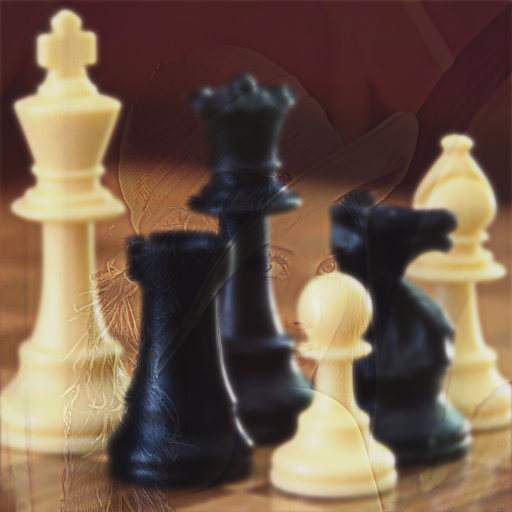

In [8]:
model = MyModel(512, 512, gauss_kernel_size=15)
r = model.train(steps_count=200, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_blurred=imgs[1], m_precise=0.1, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 26074.14387783049, precise = 72150.23218472222, gauss = 4429.074222413828
99: loss = 25778.177202294144, precise = 67303.20045274144, gauss = 5587.217066471714
149: loss = 25703.375968382225, precise = 65652.82001822015, gauss = 6007.529962916177
199: loss = 25672.760883117764, precise = 65018.68135383865, gauss = 6167.15647696617
249: loss = 25655.1635186341, precise = 64747.88794180544, gauss = 6230.797136092467
299: loss = 25643.15510516904, precise = 64620.66421439528, gauss = 6256.955840850457
349: loss = 25634.251186732243, precise = 64555.4321787915, gauss = 6267.621533094793
399: loss = 25627.331917072137, precise = 64519.185189612406, gauss = 6271.5763601884155
449: loss = 25621.783581519936, precise = 64497.4993368358, gauss = 6272.533780469201
499: loss = 25617.229021010215, precise = 64483.620553589484, gauss = 6272.1428549333705


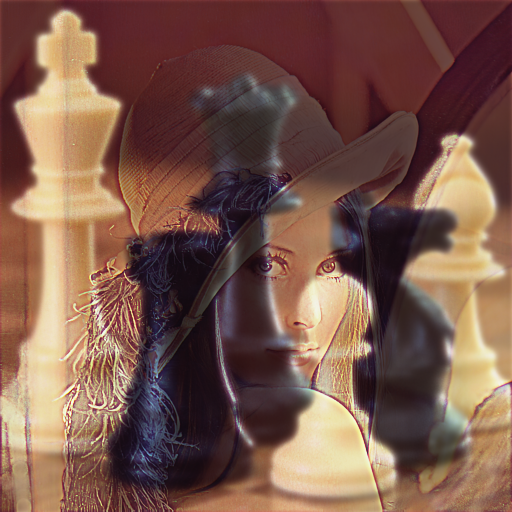

In [9]:
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_blurred=imgs[1], m_precise=0.3, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 55666.843280165354, precise = 25884.220963900472, gauss = 29782.622316264886
99: loss = 54846.07723536335, precise = 26572.85459801277, gauss = 28273.222637350576
149: loss = 54709.47559606173, precise = 26672.362068078586, gauss = 28037.11352798315
199: loss = 54661.121836750724, precise = 26690.794733852865, gauss = 27970.327102897856
249: loss = 54637.86921952994, precise = 26695.03058388699, gauss = 27942.838635642947
299: loss = 54624.6496429549, precise = 26696.27880526937, gauss = 27928.370837685536
349: loss = 54616.279309592195, precise = 26696.84639503113, gauss = 27919.432914561068
399: loss = 54610.56291004541, precise = 26697.272610177526, gauss = 27913.29029986788
449: loss = 54606.43552001457, precise = 26697.684970343085, gauss = 27908.750549671488
499: loss = 54603.3278194468, precise = 26698.105716013637, gauss = 27905.22210343316


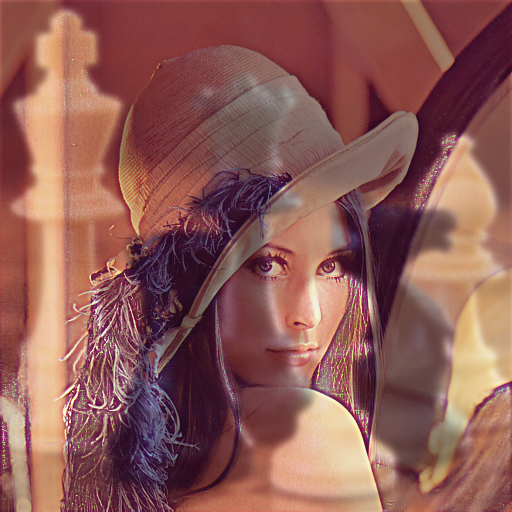

In [10]:
model = MyModel(512, 512, gauss_kernel_size=15)
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_blurred=imgs[1], m_precise=1.0, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 12443.185492434597, precise = 89644.97654875072, gauss = 3478.6878375595234
99: loss = 10953.842386779563, precise = 93185.04978088074, gauss = 1635.3374086914876
149: loss = 10712.776166753334, precise = 94425.75306730797, gauss = 1270.2008600225354
199: loss = 10634.603407723931, precise = 94875.87169727395, gauss = 1147.0162379965352
249: loss = 10598.263958206131, precise = 95039.46067508176, gauss = 1094.317890697953
299: loss = 10577.513600987715, precise = 95090.99102344859, gauss = 1068.4144986428566
349: loss = 10564.016051261086, precise = 95096.16310303213, gauss = 1054.399740957871
399: loss = 10554.419458640428, precise = 95081.64623401473, gauss = 1046.2548352389556
449: loss = 10547.146945520826, precise = 95058.95071838655, gauss = 1041.2518736821712
499: loss = 10541.368861995776, precise = 95033.27334763802, gauss = 1038.0415272319729


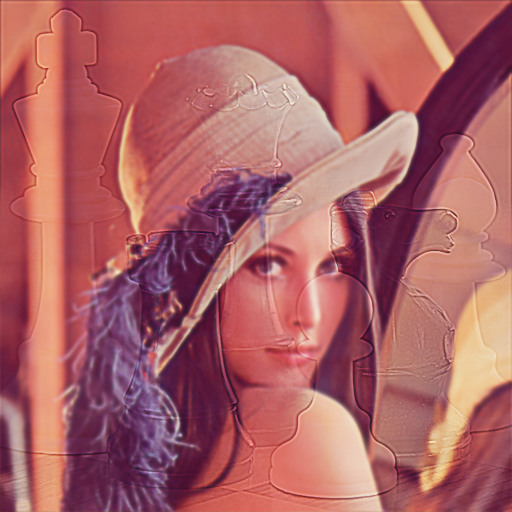

In [11]:
model = MyModel(512, 512, gauss_kernel_size=11)
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[1], img_blurred=imgs[0], m_precise=0.1, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))